In [1]:
#import modules
import osmnx as ox
import networkx as nx
import geopandas as gpd
import pandas as pd
import pandana as pdna
import numpy as np
from scipy.stats import zscore
import gc
import os
import csv
import matplotlib.pyplot as plt
%matplotlib inline
from shapely.geometry import Polygon, mapping


In [2]:
#Import graphml, convert to undirected
graphml_path = "belfast_gb_2019_10000m_all_osm_20190902.graphml"
G = ox.load_graphml(graphml_path)
G_undirected = ox.save_load.get_undirected(G)
gdf_osm = ox.save_load.graph_to_gdfs(G_undirected, nodes=False, edges=True)


In [3]:
#Impport study area
osm_buffer_file="belfast_gb_2019_1600m_buffer.gpkg"
gdf_study_area = gpd.read_file(osm_buffer_file, layer='urban_study_region')

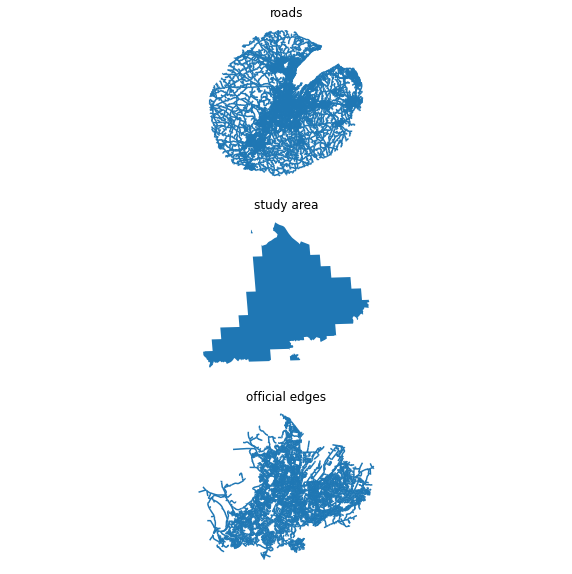

In [4]:
#pdf_study_area = gpd.read_file(graphml_path, layer='urban_study_region')
#Import official shape file of network
gdf_official = gpd.GeoDataFrame.from_file("Belfast_City_Council_Area_Street_Network.shp")

#Convert crs of osm dataset and study area to crs to official dataset
gdf_osm = gdf_osm.to_crs(gdf_official.crs)
gdf_study_area = gdf_study_area.to_crs(gdf_official.crs)

#Plot the datasets
fig, (ax1,ax2, ax3) = plt.subplots(3, 1, figsize=( 10, 10))
gdf_osm.plot(ax=ax1)
gdf_study_area.plot(ax=ax2)
gdf_official.plot(ax=ax3)
ax1.set_title("roads")
ax2.set_title("study area")
ax3.set_title("official edges")
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()
plt.axis('equal')
plt.show()

In [6]:

#gdf_official.to_file("olomouc_official.shp")


In [7]:
#gdf_study_area.to_file("olomouc_study_area.shp")

In [8]:
#gdf_osm.to_file("olomouc_osm.shp")


/opt/conda/lib/python3.7/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()
/opt/conda/lib/python3.7/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the ol

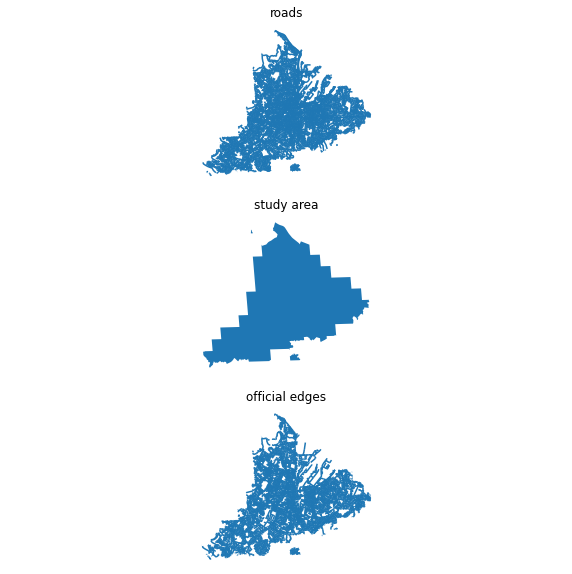

In [5]:
#Clip datasets by study are boundary
#mask1 = gdf_osm['geometry'].intersects(gdf_study_area['geometry'].unary_union)
osm_data = gpd.clip(gdf_osm, gdf_study_area)
#mask2 = gdf_official['geometry'].intersects(gdf_study_area['geometry'].unary_union)
official_data = gpd.clip(gdf_official, gdf_study_area)

#Plot the clipped dataset
fig, (ax1,ax2, ax3) = plt.subplots(3, 1, figsize=( 10, 10))
osm_data.plot(ax=ax1)
gdf_study_area.plot(ax=ax2)
official_data.plot(ax=ax3)
ax1.set_title("roads")
ax2.set_title("study area")
ax3.set_title("official edges")
ax1.set_axis_off()
ax2.set_axis_off()
ax3.set_axis_off()
plt.axis('equal')
plt.show()

In [6]:
# Export the clipped datasets to shapefile
from os.path import join as pjoin
filename = "belfast_official.shp"
path_to_file = pjoin("output", filename)

if os.path.isfile(path_to_file):
    print ("File exist")
else:
    official_data.to_file(path_to_file)
    
filename = "belfast_osm.shp"
path_to_file = pjoin("output", filename)
#gdf_osm = pd.merge(gdf_osm, gdf_osm.bounds, left_index=True, right_index=True)


if os.path.isfile(path_to_file):
    print ("File exist")
else:
    osm_data[['length', 'geometry']].to_file(path_to_file)

filename = "belfast_study_area.shp"
path_to_file = pjoin("output", filename)
#gdf_study_area = pd.merge(gdf_study_area, gdf_study_area.bounds, left_index=True, right_index=True)

if os.path.isfile(path_to_file):
    print ("File exist")
else:
    gdf_study_area.to_file(path_to_file)

In [7]:
#Calculating the total length of osm network
totallength = 0
count_osm = 0 
osmlength = osm_data.length
for i in osmlength:
    count_osm += 1
    totallength += i
print(totallength, count_osm)

1700228.419254998 26244


In [8]:
#Calculate total length of official network
totallength2 = 0
count_of = 0 
oflength = official_data.length
for i in oflength:
    count_of += 1
    totallength2 += i
print(totallength2, count_of)

1330205.3149234927 18662


In [9]:
#calculate areal intersection with various buffering 
buff = 5
percent_list = []
percent_dict = {}

while buff<20:
    
    
    official_buffer = official_data
    official_buffer = official_buffer.buffer(buff)

    osm_buffer = osm_data
    osm_buffer = osm_buffer.buffer(buff)

    
    osm_total = 0
    osm_areas = osm_buffer.area
    for i in osm_areas:
        osm_total += i
   # print(osm_areas[0:3])
    
    official_total = 0
    official_areas = official_buffer.area
    for i in official_areas:
        official_total += i
    #print(official_areas[0:3])
    print("osm areas: ", osm_total)
    print("official areas: ", official_total)
    
    intersected = gpd.clip(official_buffer, osm_buffer)

    totalshare = 0
    in_areas = intersected.area
    for i in in_areas:
        totalshare += i
    print(totalshare)
    percent_official_intersected = totalshare*100/official_total
    print("intersected: ",totalshare)
    print("intersected length: ", len(intersected))
    print("percent_official_intersected: ", percent_official_intersected)
    percent_dict[buff] = percent_official_intersected
    percent_list.append((buff,percent_official_intersected))
    buff += 5
    
   

osm areas:  19034504.29251462
official areas:  14763241.83523852


/opt/conda/lib/python3.7/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


11925070.385345986
intersected:  11925070.385345986
intersected length:  18085
percent_official_intersected:  80.77541855937037
osm areas:  42114182.29836782
official areas:  32439029.046362787


/opt/conda/lib/python3.7/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


28315601.101539295
intersected:  28315601.101539295
intersected length:  18288
percent_official_intersected:  87.28868259610924
osm areas:  69234382.28524312
official areas:  53015213.99517314


/opt/conda/lib/python3.7/site-packages/geopandas/geoseries.py:358: UserWarning: GeoSeries.notna() previously returned False for both missing (None) and empty geometries. Now, it only returns False for missing values. Since the calling GeoSeries contains empty geometries, the result has changed compared to previous versions of GeoPandas.
Given a GeoSeries 's', you can use '~s.is_empty & s.notna()' to get back the old behaviour.

To further ignore this warning, you can do: 
import warnings; warnings.filterwarnings('ignore', 'GeoSeries.notna', UserWarning)
  return self.notna()


48205798.48081814
intersected:  48205798.48081814
intersected length:  18409
percent_official_intersected:  90.92823521415403


In [10]:
for item in percent_list:
    print("buffer: ", item[0])
    print("Percent area intersected: ", item[1])
    print("-----------------------")


buffer:  5
Percent area intersected:  80.77541855937037
-----------------------
buffer:  10
Percent area intersected:  87.28868259610924
-----------------------
buffer:  15
Percent area intersected:  90.92823521415403
-----------------------
